In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../../data"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'market_test_df.csv', 'market_train_df.csv', 'market_train_df_head.csv', 'news_train_df_head.csv']


In [4]:
import numpy as np
import lightgbm as lgb
import pandas as pd
#from kaggle.competitions import twosigmanews
import matplotlib.pyplot as plt
import random
from datetime import datetime, date
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import time

/Users/alex/Desktop/Coding/AI/two-sigma-kaggle/env3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
# official way to get the data
#from kaggle.competitions import twosigmanews
#env = twosigmanews.make_env()
#print('Done!')

In [5]:
market_train_df = pd.read_csv("../../data/market_train_df.csv").drop('Unnamed: 0', axis=1)

In [10]:
market_train_df['time'] = pd.to_datetime(market_train_df['time']).dt.date
market_train_df = market_train_df.loc[market_train_df['time']>=date(2010, 1, 1)]

In [11]:
from multiprocessing import Pool

def create_lag(df_code,n_lag=[3,7,14,],shift_size=1):
    code = df_code['assetCode'].unique()
    
    for col in return_features:
        for window in n_lag:
            rolled = df_code[col].shift(shift_size).rolling(window=window)
            lag_mean = rolled.mean()
            lag_max = rolled.max()
            lag_min = rolled.min()
            lag_std = rolled.std()
            df_code['%s_lag_%s_mean'%(col,window)] = lag_mean
            df_code['%s_lag_%s_max'%(col,window)] = lag_max
            df_code['%s_lag_%s_min'%(col,window)] = lag_min
#             df_code['%s_lag_%s_std'%(col,window)] = lag_std
    return df_code.fillna(-1)

def generate_lag_features(df,n_lag = [3,7,14]):
    features = ['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe']
    
    assetCodes = df['assetCode'].unique()
    print(assetCodes)
    all_df = []
    df_codes = df.groupby('assetCode')
    df_codes = [df_code[1][['time','assetCode']+return_features] for df_code in df_codes]
    print('total %s df'%len(df_codes))
    
    pool = Pool(4)
    all_df = pool.map(create_lag, df_codes)
    
    new_df = pd.concat(all_df)  
    new_df.drop(return_features,axis=1,inplace=True)
    pool.close()
    
    return new_df

In [12]:
# return_features = ['close']
# new_df = generate_lag_features(market_train_df,n_lag = 5)
# market_train_df = pd.merge(market_train_df,new_df,how='left',on=['time','assetCode'])

In [13]:
return_features = ['returnsClosePrevMktres10','returnsClosePrevRaw10','open','close']
n_lag = [3,7,14]
new_df = generate_lag_features(market_train_df,n_lag=n_lag)
market_train_df = pd.merge(market_train_df,new_df,how='left',on=['time','assetCode'])

['A.N' 'AAI.N' 'AAP.N' ... 'HASI.N' 'NPTN.N' 'APFH.N']
total 3274 df


In [14]:
print(market_train_df.columns)

Index(['time', 'assetCode', 'assetName', 'volume', 'close', 'open',
       'returnsClosePrevRaw1', 'returnsOpenPrevRaw1',
       'returnsClosePrevMktres1', 'returnsOpenPrevMktres1',
       'returnsClosePrevRaw10', 'returnsOpenPrevRaw10',
       'returnsClosePrevMktres10', 'returnsOpenPrevMktres10',
       'returnsOpenNextMktres10', 'universe',
       'returnsClosePrevMktres10_lag_3_mean',
       'returnsClosePrevMktres10_lag_3_max',
       'returnsClosePrevMktres10_lag_3_min',
       'returnsClosePrevMktres10_lag_7_mean',
       'returnsClosePrevMktres10_lag_7_max',
       'returnsClosePrevMktres10_lag_7_min',
       'returnsClosePrevMktres10_lag_14_mean',
       'returnsClosePrevMktres10_lag_14_max',
       'returnsClosePrevMktres10_lag_14_min',
       'returnsClosePrevRaw10_lag_3_mean', 'returnsClosePrevRaw10_lag_3_max',
       'returnsClosePrevRaw10_lag_3_min', 'returnsClosePrevRaw10_lag_7_mean',
       'returnsClosePrevRaw10_lag_7_max', 'returnsClosePrevRaw10_lag_7_min',
       're

In [15]:
# return_features = ['open']
# new_df = generate_lag_features(market_train_df,n_lag=[3,7,14])
# market_train_df = pd.merge(market_train_df,new_df,how='left',on=['time','assetCode'])

In [16]:
def mis_impute(data):
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("other")
        elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

market_train_df = mis_impute(market_train_df)

In [17]:
def data_prep(market_train):
    lbl = {k: v for v, k in enumerate(market_train['assetCode'].unique())}
    market_train['assetCodeT'] = market_train['assetCode'].map(lbl)
    market_train = market_train.dropna(axis=0)
    return market_train

market_train_df = data_prep(market_train_df)
# # check the shape
print(market_train_df.shape)

(2846738, 53)


In [77]:
import os;os.listdir('../pickle')

['_ref_market_train_df.pkl',
 '_ref_models.pkl',
 'DecisionTree.model_lgbm_71.pkl']

In [79]:
import pickle as pk
pk.dump([mins,maxs,rng], open("../pickle/normalizing.pkl","wb"))

In [20]:
from sklearn.preprocessing import LabelEncoder

up = market_train_df['returnsOpenNextMktres10'] >= 0


universe = market_train_df['universe'].values
d = market_train_df['time']

fcol = [c for c in market_train_df if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'audiences', 
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train_df[fcol].values
up = up.values
r = market_train_df.returnsOpenNextMktres10.values

# Scaling of X values
# It is good to keep these scaling values for later
# they will be used during predictions!
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

# Sanity check
assert X.shape[0] == up.shape[0] == r.shape[0]

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import time

import pickle as pk
with open("../pickle/_ref_market_train_df.pkl","wb") as f:
    #dumps generated features for comparison
    pk.dump(X, f)

X_train, X_test, up_train, up_test, r_train, r_test,u_train,u_test,d_train,d_test = model_selection.train_test_split(X, up, r,universe,d, test_size=0.25, random_state=99)


# te = market_train_df['time']>date(2015, 1, 1)

# tt = 0
# for tt,i in enumerate(te.values):
#     if i:
#         idx = tt
#         print(i,tt)
#         break
# print(idx)
# # for ind_tr, ind_te in tscv.split(X):
# #     print(ind_tr)
# X_train, X_test = X[:idx],X[idx:]

# up_train, up_test = up[:idx],up[idx:]
# r_train, r_test = r[:idx],r[idx:]
# u_train,u_test = universe[:idx],universe[idx:]
# d_train,d_test = d[:idx],d[idx:]

# train_data = lgb.Dataset(X_train, label=up_train.astype(int))
train_data = lgb.Dataset(X, label=up.astype(int))
test_data = lgb.Dataset(X_test, label=up_test.astype(int))

In [21]:
# these are tuned params I found
x_1 = [0.19000424246380565, 2452, 212, 239, 202]
x_2 = [0.19016805202090095, 2583, 213, 172, 220]
x_3 = [0.19564034613157152, 2452, 210, 160, 219]
x_4 = [0.19016805202090095, 2500, 213, 150, 202]
x_5 = [0.19000424246380565, 2600, 215, 140, 220]
x_6 = [0.19000424246380565, 2652, 216, 152, 202]

"""
x_1 = [0.19000424246380565, 2452, 212, 328, 202]
x_2 = [0.19016805202090095, 2583, 213, 312, 220]
x_3 = [0.19564034613157152, 2455, 210, 330, 219]
x_4 = [0.15000000000000000, 2600, 220, 340, 202]
x_5 = [0.15000000000000000, 2600, 220, 330, 220]
x_6 = [0.15000000000000000, 2400, 220, 340, 202]
"""
print(up_train)
def exp_loss(p,y):
    y = y.get_label()
#     p = p.get_label()
    grad = -y*(1.0-1.0/(1.0+np.exp(-y*p)))
    hess = -(np.exp(y*p)*(y*p-1)-1)/((np.exp(y*p)+1)**2)
    
    return grad,hess

params_1 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'objective': 'regression',
        'learning_rate': x_1[0],
        'num_leaves': x_1[1],
        'min_data_in_leaf': x_1[2],
#         'num_iteration': x_1[3],
        'num_iteration': 239,
        'max_bin': x_1[4],
        'verbose': 1
    }

params_2 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
#         'objective': 'regression',
        'learning_rate': x_2[0],
        'num_leaves': x_2[1],
        'min_data_in_leaf': x_2[2],
#         'num_iteration': x_2[3],
        'num_iteration': 172,
        'max_bin': x_2[4],
        'verbose': 1
    }

params_3 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': x_3[0],
        'num_leaves': x_3[1],
        'min_data_in_leaf': x_3[2],
        'num_iteration': x_3[3],
        'max_bin': x_3[4],
        'verbose': 1
    }

params_4 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': x_4[0],
        'num_leaves': x_4[1],
        'min_data_in_leaf': x_4[2],
        'num_iteration': x_4[3],
        'max_bin': x_4[4],
        'verbose': 1
    }

params_5 = {
        'task': 'train',
        'boosting_type': 'gbdt',#dart
        'objective': 'binary',
        'learning_rate': x_5[0],
        'num_leaves': x_5[1],
        'min_data_in_leaf': x_5[2],
        'num_iteration': x_5[3],
        'max_bin': x_5[4],
        'verbose': 1
    }

params_6 = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'learning_rate': x_6[0],
        'num_leaves': x_6[1],
        'min_data_in_leaf': x_6[2],
        'num_iteration': x_6[3],
        'max_bin': x_6[4],
        'verbose': 1
    }

gbm_1 = lgb.train(params_1,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )

gbm_2 = lgb.train(params_2,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )

gbm_3 = lgb.train(params_3,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )

gbm_4 = lgb.train(params_4,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )

gbm_5 = lgb.train(params_5,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=5,
#         fobj=exp_loss,
        )


gbm_6 = lgb.train(params_6,
        train_data,
        num_boost_round=100,
        valid_sets=test_data,
        early_stopping_rounds=10,
#         fobj=exp_loss,
        )


[ True  True False ... False False  True]


/Users/alex/Desktop/Coding/AI/two-sigma-kaggle/env3/lib/python3.7/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's binary_logloss: 0.686931
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.682219
[3]	valid_0's binary_logloss: 0.678278
[4]	valid_0's binary_logloss: 0.674929
[5]	valid_0's binary_logloss: 0.67202
[6]	valid_0's binary_logloss: 0.66939
[7]	valid_0's binary_logloss: 0.667001
[8]	valid_0's binary_logloss: 0.664809
[9]	valid_0's binary_logloss: 0.662691
[10]	valid_0's binary_logloss: 0.660414
[11]	valid_0's binary_logloss: 0.658421
[12]	valid_0's binary_logloss: 0.656347
[13]	valid_0's binary_logloss: 0.654358
[14]	valid_0's binary_logloss: 0.652363
[15]	valid_0's binary_logloss: 0.650411
[16]	valid_0's binary_logloss: 0.648334
[17]	valid_0's binary_logloss: 0.646779
[18]	valid_0's binary_logloss: 0.644703
[19]	valid_0's binary_logloss: 0.643046
[20]	valid_0's binary_logloss: 0.640843
[21]	valid_0's binary_logloss: 0.639291
[22]	valid_0's binary_logloss: 0.63769
[23]	valid_0's binary_logloss: 0.634964
[24]	valid_0's binary_logloss: 

[203]	valid_0's binary_logloss: 0.443608
[204]	valid_0's binary_logloss: 0.442835
[205]	valid_0's binary_logloss: 0.442163
[206]	valid_0's binary_logloss: 0.441452
[207]	valid_0's binary_logloss: 0.440733
[208]	valid_0's binary_logloss: 0.440091
[209]	valid_0's binary_logloss: 0.439227
[210]	valid_0's binary_logloss: 0.438611
[211]	valid_0's binary_logloss: 0.437945
[212]	valid_0's binary_logloss: 0.436973
[213]	valid_0's binary_logloss: 0.4363
[214]	valid_0's binary_logloss: 0.435618
[215]	valid_0's binary_logloss: 0.434974
[216]	valid_0's binary_logloss: 0.434278
[217]	valid_0's binary_logloss: 0.433091
[218]	valid_0's binary_logloss: 0.432368
[219]	valid_0's binary_logloss: 0.431697
[220]	valid_0's binary_logloss: 0.431087
[221]	valid_0's binary_logloss: 0.430351
[222]	valid_0's binary_logloss: 0.429647
[223]	valid_0's binary_logloss: 0.428683
[224]	valid_0's binary_logloss: 0.427928
[225]	valid_0's binary_logloss: 0.427254
[226]	valid_0's binary_logloss: 0.426647
[227]	valid_0's bi

[164]	valid_0's binary_logloss: 0.468515
[165]	valid_0's binary_logloss: 0.467672
[166]	valid_0's binary_logloss: 0.466775
[167]	valid_0's binary_logloss: 0.465748
[168]	valid_0's binary_logloss: 0.464815
[169]	valid_0's binary_logloss: 0.464105
[170]	valid_0's binary_logloss: 0.463353
[171]	valid_0's binary_logloss: 0.462519
[172]	valid_0's binary_logloss: 0.461719
Did not meet early stopping. Best iteration is:
[172]	valid_0's binary_logloss: 0.461719
[1]	valid_0's binary_logloss: 0.686769
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.681962
[3]	valid_0's binary_logloss: 0.677973
[4]	valid_0's binary_logloss: 0.674553
[5]	valid_0's binary_logloss: 0.671679
[6]	valid_0's binary_logloss: 0.669038
[7]	valid_0's binary_logloss: 0.666435
[8]	valid_0's binary_logloss: 0.664255
[9]	valid_0's binary_logloss: 0.662049
[10]	valid_0's binary_logloss: 0.660061
[11]	valid_0's binary_logloss: 0.657852
[12]	valid_0's binary_logloss: 0.655755
[13]	valid

[29]	valid_0's binary_logloss: 0.624071
[30]	valid_0's binary_logloss: 0.621836
[31]	valid_0's binary_logloss: 0.620529
[32]	valid_0's binary_logloss: 0.619241
[33]	valid_0's binary_logloss: 0.617765
[34]	valid_0's binary_logloss: 0.616527
[35]	valid_0's binary_logloss: 0.615427
[36]	valid_0's binary_logloss: 0.613186
[37]	valid_0's binary_logloss: 0.611925
[38]	valid_0's binary_logloss: 0.610374
[39]	valid_0's binary_logloss: 0.609267
[40]	valid_0's binary_logloss: 0.607212
[41]	valid_0's binary_logloss: 0.606002
[42]	valid_0's binary_logloss: 0.604647
[43]	valid_0's binary_logloss: 0.603551
[44]	valid_0's binary_logloss: 0.602209
[45]	valid_0's binary_logloss: 0.601097
[46]	valid_0's binary_logloss: 0.599973
[47]	valid_0's binary_logloss: 0.598631
[48]	valid_0's binary_logloss: 0.597387
[49]	valid_0's binary_logloss: 0.595565
[50]	valid_0's binary_logloss: 0.594176
[51]	valid_0's binary_logloss: 0.592876
[52]	valid_0's binary_logloss: 0.591447
[53]	valid_0's binary_logloss: 0.590162


[80]	valid_0's binary_logloss: 0.551533
[81]	valid_0's binary_logloss: 0.550396
[82]	valid_0's binary_logloss: 0.549398
[83]	valid_0's binary_logloss: 0.548412
[84]	valid_0's binary_logloss: 0.546797
[85]	valid_0's binary_logloss: 0.545783
[86]	valid_0's binary_logloss: 0.544355
[87]	valid_0's binary_logloss: 0.543331
[88]	valid_0's binary_logloss: 0.542203
[89]	valid_0's binary_logloss: 0.541197
[90]	valid_0's binary_logloss: 0.540147
[91]	valid_0's binary_logloss: 0.538577
[92]	valid_0's binary_logloss: 0.537628
[93]	valid_0's binary_logloss: 0.536509
[94]	valid_0's binary_logloss: 0.535547
[95]	valid_0's binary_logloss: 0.534437
[96]	valid_0's binary_logloss: 0.533342
[97]	valid_0's binary_logloss: 0.531965
[98]	valid_0's binary_logloss: 0.531048
[99]	valid_0's binary_logloss: 0.529772
[100]	valid_0's binary_logloss: 0.528844
[101]	valid_0's binary_logloss: 0.527679
[102]	valid_0's binary_logloss: 0.526626
[103]	valid_0's binary_logloss: 0.525329
[104]	valid_0's binary_logloss: 0.52

[140]	valid_0's binary_logloss: 0.486529
[141]	valid_0's binary_logloss: 0.485568
[142]	valid_0's binary_logloss: 0.484517
[143]	valid_0's binary_logloss: 0.483502
[144]	valid_0's binary_logloss: 0.482507
[145]	valid_0's binary_logloss: 0.481616
[146]	valid_0's binary_logloss: 0.480771
[147]	valid_0's binary_logloss: 0.479751
[148]	valid_0's binary_logloss: 0.478765
[149]	valid_0's binary_logloss: 0.477941
[150]	valid_0's binary_logloss: 0.477
[151]	valid_0's binary_logloss: 0.476123
[152]	valid_0's binary_logloss: 0.474917
Did not meet early stopping. Best iteration is:
[152]	valid_0's binary_logloss: 0.474917


In [30]:
models = [gbm_1, gbm_2, gbm_3, gbm_4, gbm_5, gbm_6]
import pickle as pk
pk.dump(models, open("../pickle/_ref_models.pkl","wb"))

In [52]:
_ref_models = [gbm_1, gbm_2, gbm_3, gbm_4, gbm_5, gbm_6]

In [29]:
import os
os.listdir('../pickle')

['_ref_market_train_df.pkl']

In [40]:
import sys;sys.path.append('../')

In [60]:
import model_lgbm_71
m = model_lgbm_71.model('DecisionTree.model_lgbm_71')


init model DecisionTree.model_lgbm_71


In [63]:
m._load()

[_load] models loaded succesfully


In [31]:
#实现零均值归一化操作
confidence_test = (gbm_1.predict(X_test) + gbm_2.predict(X_test)+gbm_3.predict(X_test)+gbm_4.predict(X_test)+gbm_5.predict(X_test)+gbm_6.predict(X_test))/6
confidence_test = (confidence_test-confidence_test.min())/(confidence_test.max()-confidence_test.min())
#print("max_min",max_min)
#confidence_test=(confidence_test-confidence_test.mean())/(confidence_test.std())
confidence_test = confidence_test*2-1
print(max(confidence_test),min(confidence_test))

# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test * r_test * u_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

1.0 -1.0
2.8818111760147023


In [73]:
#实现零均值归一化操作
confidence_test = (m.model1.predict(X_test) + m.model2.predict(X_test)+m.model3.predict(X_test)+m.model4.predict(X_test)+m.model5.predict(X_test)+m.model6.predict(X_test))/6
confidence_test = (confidence_test-confidence_test.min())/(confidence_test.max()-confidence_test.min())
#print("max_min",max_min)
confidence_test=(confidence_test-confidence_test.mean())/(confidence_test.std())
print(max(confidence_test),min(confidence_test))

# calculation of actual metric that is used to calculate final score
r_test = r_test.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_test * r_test * u_test
data = {'day' : d_test, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_test = mean / std
print(score_test)

2.85099536572443 -2.8744500992638584
2.876772497335684


In [38]:
X_test.shape

(711685, 48)

In [35]:
m1 = gbm_1.predict(X)

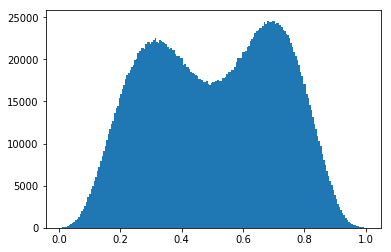

In [36]:
plt.hist(m1, bins='auto')
plt.show()

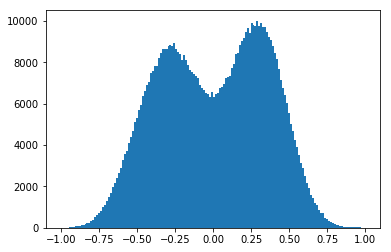

In [34]:
plt.hist(confidence_test, bins='auto')
plt.show()

In [ ]:
import gc
del X_train,X_test
gc.collect()

In [ ]:
#prediction
days = env.get_prediction_days()
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
total_market_obs_df = []
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if (n_days%50==0):
        pass
        #print(n_days,end=' ')
    t = time.time()
    market_obs_df['time'] = market_obs_df['time'].dt.date
    
    return_features = ['returnsClosePrevMktres10','returnsClosePrevRaw10','open','close']
    total_market_obs_df.append(market_obs_df)
    if len(total_market_obs_df)==1:
        history_df = total_market_obs_df[0]
    else:
        history_df = pd.concat(total_market_obs_df[-(np.max(n_lag)+1):])
    new_df = generate_lag_features(history_df,n_lag=[3,7,14])
    market_obs_df = pd.merge(market_obs_df,new_df,how='left',on=['time','assetCode'])
    market_obs_df = mis_impute(market_obs_df)
    market_obs_df = data_prep(market_obs_df)
    
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    t = time.time()
    lp = (gbm_1.predict(X_live) + gbm_2.predict(X_live)+gbm_3.predict(X_live)+gbm_4.predict(X_live)+gbm_5.predict(X_live)+gbm_6.predict(X_live))/6
    prediction_time += time.time() -t
    t = time.time()
    confidence = lp
    confidence = (confidence-confidence.min())/(confidence.max()-confidence.min())
    #print("max_min_predict",max_min_predict)
    confidence = confidence * 2 - 1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
env.write_submission_file()
sub  = pd.read_csv("submission_versionnew.csv")